LSTM MODEL

In [24]:
# !pip install tensorflow sklearn numpy matplotlib

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import os
import re


#accuracy metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [25]:
def load_and_separate_npy(directory):

    feature_files = sorted([f for f in os.listdir(directory) if 'features.npy' in f])
    target_files = sorted([f for f in os.listdir(directory) if 'targets.npy' in f])

    # print(f"Found {len(feature_files)} feature files and {len(target_files)} target files")

    data_by_year = {}
    for feature_file, target_file in zip(feature_files, target_files):
        year_match = re.search(r'(\d{4})\d{4}', feature_file)
        if year_match:
            year = int(year_match.group(1))
            features = np.load(os.path.join(directory, feature_file))
            targets = np.load(os.path.join(directory, target_file))

            #2D arrays check
            if len(features.shape) == 1:
                features = features.reshape(-1, 1)
            if len(targets.shape) == 1:
                targets = targets.reshape(-1, 1)

            # print(f"Loaded data for year {year}: Features shape {features.shape}, Targets shape {targets.shape}")
            data_by_year[year] = (features, targets)
    print("Done")
    return data_by_year

def prepare_data(data_by_year, train_years, val_years, test_year):


    train_features = []
    train_targets = []
    for year in train_years:
        if year in data_by_year:
            features, targets = data_by_year[year]
            train_features.append(features)
            train_targets.append(targets)


    val_features = []
    val_targets = []
    for year in val_years:
        if year in data_by_year:
            features, targets = data_by_year[year]
            val_features.append(features)
            val_targets.append(targets)


    test_features, test_targets = data_by_year[test_year]


    train_features = np.concatenate(train_features, axis=0)
    train_targets = np.concatenate(train_targets, axis=0)
    val_features = np.concatenate(val_features, axis=0)
    val_targets = np.concatenate(val_targets, axis=0)

    return train_features, train_targets, val_features, val_targets, test_features, test_targets

def create_model(input_shape):

    # model = Sequential([
    #     LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
    #     Dropout(0.3),
    #     LSTM(32, activation='tanh', return_sequences=False),
    #     Dropout(0.3),
    #     Dense(16, activation='relu'),
    #     Dense(1)
    # ])

    # new model
    model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),   #(0.3)
    Dense(32, activation='relu'),
    # Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
     ])
    return model

In [26]:
# If data is in Google Drive, use:
DATA_DIR = "data_5-1_array"
# If data is uploaded directly to Colab, use:
# DATA_DIR = "/content/data"

#splitting the data into train,val and test based on year
TRAIN_YEARS = range(2013, 2021)
VAL_YEARS = range(2021, 2024)
TEST_YEAR = 2024


EPOCHS = 500
BATCH_SIZE = 16
LEARNING_RATE = 0.001      #0.001


In [27]:
print("Loading data...")
data_by_year = load_and_separate_npy(DATA_DIR)


print("\nPreparing datasets...")
train_features, train_targets, val_features, val_targets, test_features, test_targets = prepare_data(
    data_by_year, TRAIN_YEARS, VAL_YEARS, TEST_YEAR
)


feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)


#lstm takes 3 inputs (expand_dim does that)
X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Loading data...
Done

Preparing datasets...

Data shapes:
Training: (152, 5, 1), (152, 1)
Validation: (57, 5, 1), (57, 1)
Test: (19, 5, 1), (19, 1)


In [29]:
print("Creating model...")
model = create_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])
model.summary()

Creating model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#early stopping if loss doesn't change for 15 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience= 15,    #15
    restore_best_weights=True,
    verbose=1
)
#reduce the learning rate if it stays same for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,    #0.5
    patience=5,   #5
    min_lr=1e-6,       #1e-6
    verbose=1
)


print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Training model...
Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.1425 - mae: 0.2944 - val_loss: 0.0432 - val_mae: 0.1875 - learning_rate: 0.0010
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0571 - mae: 0.2070 - val_loss: 0.0396 - val_mae: 0.1549 - learning_rate: 0.0010
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0414 - mae: 0.1491 - val_loss: 0.0403 - val_mae: 0.1480 - learning_rate: 0.0010
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0460 - mae: 0.1675 - val_loss: 0.0354 - val_mae: 0.1599 - learning_rate: 0.0010
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0426 - mae: 0.1661 - val_loss: 0.0347 - val_mae: 0.1388 - learning_rate: 0.0010
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0401 - mae: 0.1505 - val_loss: 0.0323 - val_mae: 0.1362 - learning_rate: 0.0010
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0362 - mae: 0.1511 - val_loss: 0.0309 - val_mae: 0.1285 - learning_

In [11]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025 - mae: 0.0406 
Train Loss: 0.0025, Train MAE: 0.0405


In [12]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0026 - mae: 0.0373
Val Loss: 0.0025, Val MAE: 0.0356


In [13]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0026 - mae: 0.0392
Test Loss: 0.0026, Test MAE: 0.0392


In [14]:
#Since the data is normalized using minmaxscaler, it should be changed to it's original form before checking accuracy (.inverse_transform)

y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)


# mse = np.mean((y_test_inverse - y_pred_inverse) ** 2)
# mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# mae = np.mean(np.abs(y_test_inverse - y_pred_inverse))
# mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test, y_pred)
print(f"\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step

Performance Metrics:
MSE: 0.0026
RMSE: 0.0511
MAE: 0.0392
R2: 0.9504


Visualization

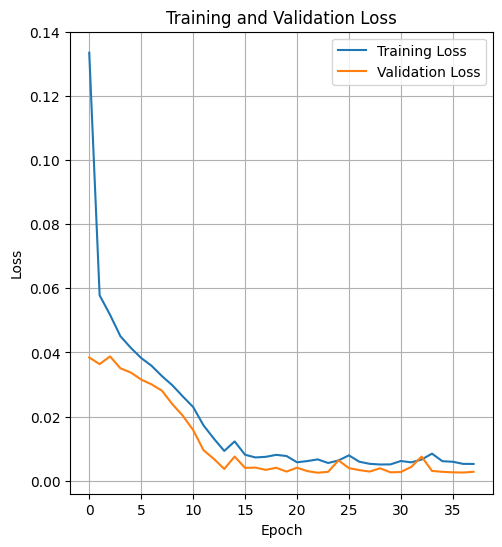

In [15]:
#subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

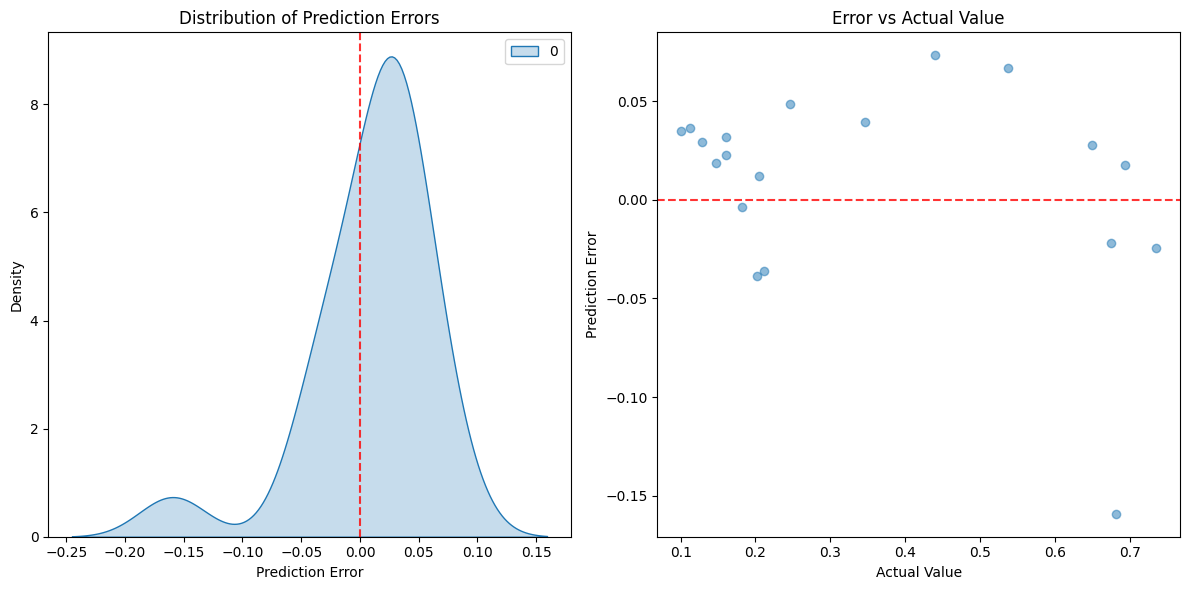

In [16]:
#kdeplot and scatter plot
plt.figure(figsize=(12, 6))
errors = y_pred - y_test
plt.subplot(1, 2, 1)
sns.kdeplot(errors, fill=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.scatter(y_test, errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.title('Error vs Actual Value')
plt.xlabel('Actual Value')
plt.ylabel('Prediction Error')
plt.tight_layout()
plt.show()

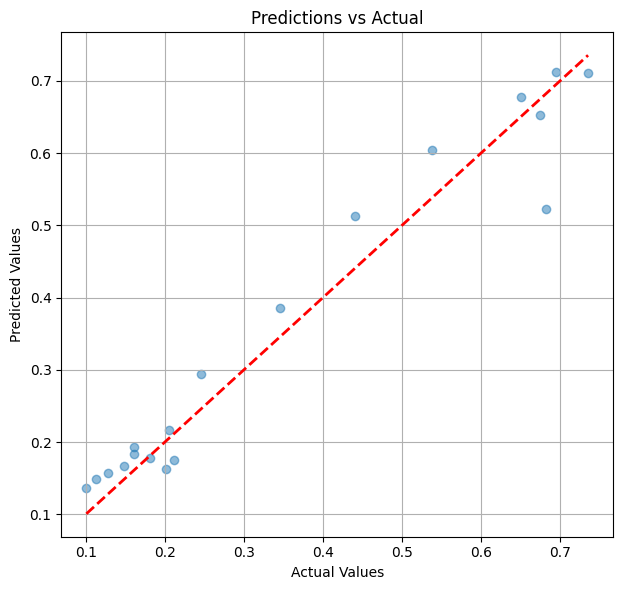

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.save('heatwave_model_lstm.keras')

LSTM+TRANSFORMER MODEL

In [30]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [31]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)

X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Data shapes:
Training: (152, 5, 1), (152, 1)
Validation: (57, 5, 1), (57, 1)
Test: (19, 5, 1), (19, 1)


In [32]:
def create_lstm_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layer
    x = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attention_output)

    # LSTM layer
    x = LSTM(64, activation='tanh', return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Dense layers
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)


model = create_lstm_transformer_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 5, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_8 (LSTM)                 │ (None, 5, 128)            │          66,560 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 5, 128)            │               0 │ lstm_8[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 5, 128)            │         131,968 │ dropout_8[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 5, 128)            │               0 │ dropout_8[0][0],           │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 5, 128)            │             256 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_9 (LSTM)                 │ (None, 64)                │          49,408 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 64)                │               0 │ lstm_9[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 32)                │           2,080 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1)                 │              33 │ dense_8[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 250,305 (977.75 KB)

 Trainable params: 250,305 (977.75 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=64, #16
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 593ms/step - loss: 0.1980 - mae: 0.3583 - val_loss: 0.0584 - val_mae: 0.1845 - learning_rate: 0.0010
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0985 - mae: 0.2315 - val_loss: 0.0323 - val_mae: 0.1583 - learning_rate: 0.0010
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0619 - mae: 0.1950 - val_loss: 0.0494 - val_mae: 0.1953 - learning_rate: 0.0010
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0633 - mae: 0.2006 - val_loss: 0.0407 - val_mae: 0.1538 - learning_rate: 0.0010
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0582 - mae: 0.1805 - val_loss: 0.0337 - val_mae: 0.1435 - learning_rate: 0.0010
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0462 - mae: 0.1639 - val_loss: 0.0321 - val_mae: 0.1427 - learning_rate: 0.0010
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0466 - mae: 0.1765 - val_loss: 0.0305 - val_mae: 0.1379 - learning_rate: 0.0010
Epoch 8/500
3/3 ━

In [34]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - mae: 0.0401
Train Loss: 0.0028, Train MAE: 0.0401


In [35]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0018 - mae: 0.0346
Val Loss: 0.0019, Val MAE: 0.0354


In [36]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0019 - mae: 0.0368
Test Loss: 0.0019, Test MAE: 0.0368


In [37]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step

Performance Metrics:
MSE: 0.0019
RMSE: 0.0434
MAE: 0.0368
R2: 0.9641


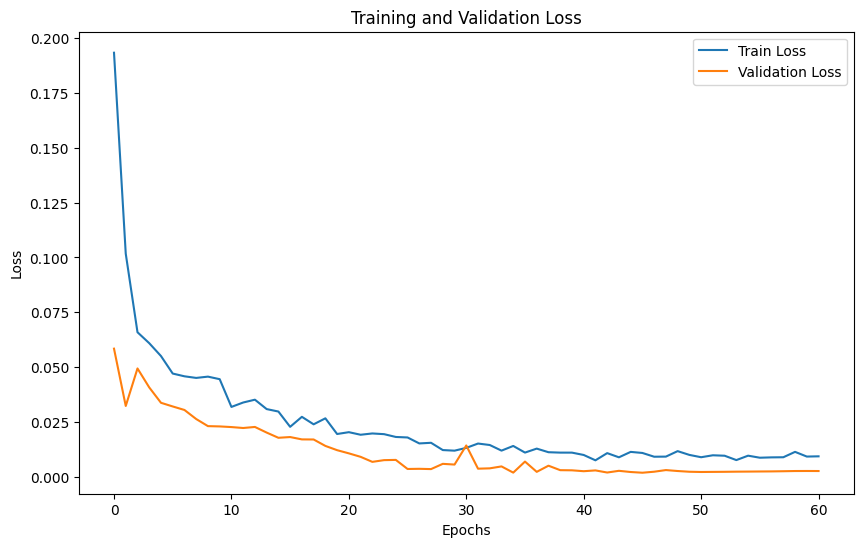

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

GRU MDOEL

In [28]:
from tensorflow.keras.layers import Input, GRU, Dropout, Dense

In [29]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)

X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")



Data shapes:
Training: (152, 5, 1), (152, 1)
Validation: (38, 5, 1), (38, 1)
Test: (19, 5, 1), (19, 1)


In [30]:
def create_gru_model(input_shape):
    # Input Layer
    inputs = Input(shape=input_shape)

    # First GRU Layer
    x = GRU(128, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(0.3)(x)

    # Second GRU Layer
    x = GRU(64, activation='tanh', return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Dense Layer
    x = Dense(32, activation='relu')(x)


    outputs = Dense(1)(x)


    return Model(inputs, outputs)


In [31]:
model = create_gru_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 5, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 5, 128)              │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,665 (350.25 KB)

 Trainable params: 89,665 (350.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - loss: 0.1439 - mae: 0.2800 - val_loss: 0.0557 - val_mae: 0.2114 - learning_rate: 0.0010
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0620 - mae: 0.2140 - val_loss: 0.0314 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0318 - mae: 0.1227 - val_loss: 0.0233 - val_mae: 0.1208 - learning_rate: 0.0010
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0270 - mae: 0.1265 - val_loss: 0.0210 - val_mae: 0.1035 - learning_rate: 0.0010
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0234 - mae: 0.1150 - val_loss: 0.0193 - val_mae: 0.1012 - learning_rate: 0.0010
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0189 - mae: 0.0997 - val_loss: 0.0161 - val_mae: 0.0917 - learning_rate: 0.0010
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0171 - mae: 0.0924 - val_loss: 0.0122 - val_mae: 0.0777 - learning_rate: 0.0010
Epoch

In [34]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {loss:.4f}, Train MAE: {mae:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - mae: 0.0299
Train Loss: 0.0015, Train MAE: 0.0309


In [36]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Val Loss: {loss:.4f}, Val MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0014 - mae: 0.0281
Val Loss: 0.0013, Val MAE: 0.0270


In [37]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0012 - mae: 0.0272
Test Loss: 0.0012, Test MAE: 0.0272


In [38]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step

Performance Metrics:
MSE: 0.0012
RMSE: 0.0342
MAE: 0.0272
R2: 0.9777


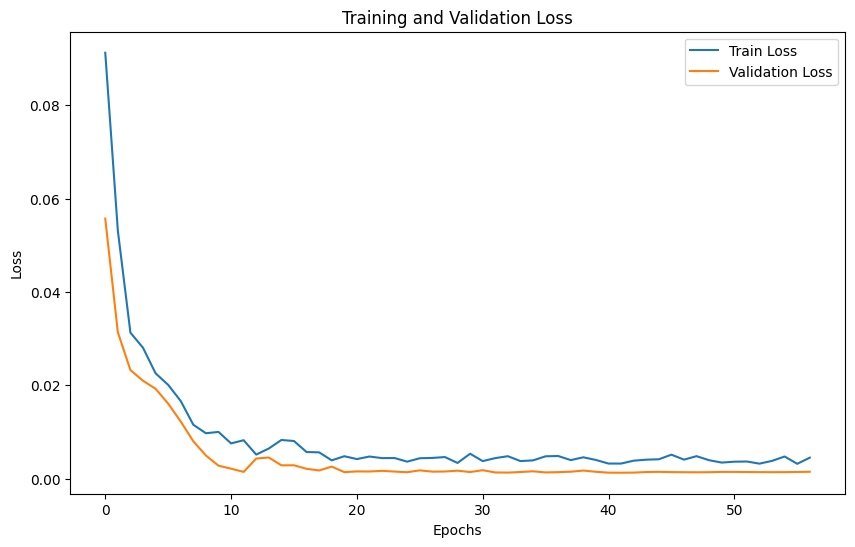

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

GRU+TRANSFORMER MODEL

In [40]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_train_targets = target_scaler.fit_transform(train_targets)
scaled_val_features = feature_scaler.transform(val_features)
scaled_val_targets = target_scaler.transform(val_targets)
scaled_test_features = feature_scaler.transform(test_features)
scaled_test_targets = target_scaler.transform(test_targets)

X_train = np.expand_dims(scaled_train_features, axis=2)
y_train = scaled_train_targets
X_val = np.expand_dims(scaled_val_features, axis=2)
y_val = scaled_val_targets
X_test = np.expand_dims(scaled_test_features, axis=2)
y_test = scaled_test_targets

print("\nData shapes:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")



Data shapes:
Training: (152, 5, 1), (152, 1)
Validation: (38, 5, 1), (38, 1)
Test: (19, 5, 1), (19, 1)


In [41]:
def create_gru_transformer_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # GRU layer to capture sequential patterns
    gru_out = GRU(128, activation='tanh', return_sequences=True)(inputs)
    gru_out = Dropout(0.3)(gru_out)

    # MultiHeadAttention layer (Transformer component)
    attention_out = MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)
    attention_out = LayerNormalization()(attention_out)
    attention_out = Dropout(0.3)(attention_out)

    # GRU layer after attention
    gru_out2 = GRU(64, activation='tanh', return_sequences=False)(attention_out)
    gru_out2 = Dropout(0.3)(gru_out2)

    # Fully connected layers
    dense_out = Dense(32, activation='relu')(gru_out2)
    output = Dense(1)(dense_out)

    # Create model
    model = Model(inputs=inputs, outputs=output)
    return model


In [42]:
model = create_gru_transformer_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 5, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_2 (GRU)                   │ (None, 5, 128)            │          50,304 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 5, 128)            │               0 │ gru_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 5, 128)            │         131,968 │ dropout_9[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 5, 128)            │             256 │ multi_head_attention_1[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 5, 128)            │               0 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_3 (GRU)                   │ (None, 64)                │          37,248 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 64)                │               0 │ gru_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 32)                │           2,080 │ dropout_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1)                 │              33 │ dense_8[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 221,889 (866.75 KB)

 Trainable params: 221,889 (866.75 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - loss: 0.3440 - mae: 0.4225 - val_loss: 0.0408 - val_mae: 0.1826 - learning_rate: 0.0010
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0771 - mae: 0.2228 - val_loss: 0.0441 - val_mae: 0.1459 - learning_rate: 0.0010
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0522 - mae: 0.1696 - val_loss: 0.0359 - val_mae: 0.1439 - learning_rate: 0.0010
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0670 - mae: 0.1991 - val_loss: 0.0394 - val_mae: 0.1423 - learning_rate: 0.0010
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0518 - mae: 0.1704 - val_loss: 0.0383 - val_mae: 0.1370 - learning_rate: 0.0010
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0449 - mae: 0.1617 - val_loss: 0.0299 - val_mae: 0.1265 - learning_rate: 0.0010
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0487 - mae: 0.1709 - val_loss: 0.0430 - val_mae: 0.1592 - learning_rate: 0.0010
Epoc

In [45]:
loss, mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024 - mae: 0.0381 
Test Loss: 0.0027, Test MAE: 0.0391


In [46]:
loss, mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0016 - mae: 0.0306 
Test Loss: 0.0015, Test MAE: 0.0303


In [47]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0015 - mae: 0.0291
Test Loss: 0.0015, Test MAE: 0.0291


In [48]:
y_pred = model.predict(X_test)
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step

Performance Metrics:
MSE: 0.0015
RMSE: 0.0389
MAE: 0.0291
R2: 0.9712


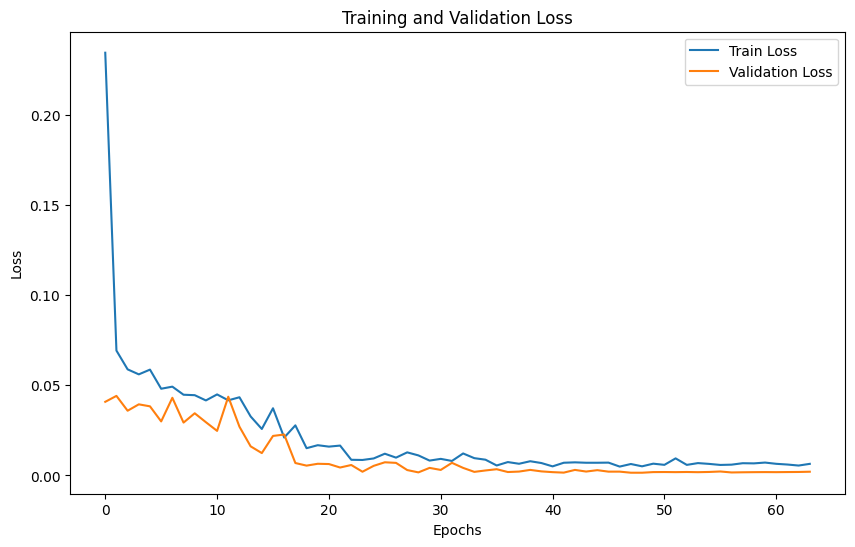

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

INTERPRETATION

In [39]:
prediction_save_path = "predicted_next_year_utci.npy"
np.save(prediction_save_path, y_pred_inverse)
print(f"\nPredicted UTCI for next year saved at {prediction_save_path}")


Predicted UTCI for next year saved at predicted_next_year_utci.npy


In [40]:
prediction_save_path = "actual_next_year_utci.npy"
np.save(prediction_save_path, y_test_inverse)
print(f"\nActual UTCI for next year saved at {prediction_save_path}")


Actual UTCI for next year saved at actual_next_year_utci.npy


In [41]:
import pandas as pd
npy_file_pred = 'predicted_next_year_utci.npy'
npy_file_true = 'actual_next_year_utci.npy'
data_pred = np.load(npy_file_pred)
data_true = np.load(npy_file_true)

data_pred_flat = data_pred.flatten()
data_true_flat = data_true.flatten()

print(data_pred_flat.shape)
print(data_true_flat.shape)
print(data_pred)
print(data_pred_flat)
print(data_true)
print(data_true_flat)
combined_data = np.column_stack((data_pred_flat, data_true_flat))

df = pd.DataFrame(combined_data, columns=['Predicted', 'Actual'])

df.to_csv('predictions_vs_actuals.csv', index=False)

print("CSV file has been created.")

(19,)
(19,)
[[34.542885]
 [36.35825 ]
 [36.44986 ]
 [36.257607]
 [35.602325]
 [34.64123 ]
 [33.31816 ]
 [31.632477]
 [30.226385]
 [28.788927]
 [28.305538]
 [28.465641]
 [28.403702]
 [28.324932]
 [28.260792]
 [28.207333]
 [28.157608]
 [28.098223]
 [28.044409]]
[34.542885 36.35825  36.44986  36.257607 35.602325 34.64123  33.31816
 31.632477 30.226385 28.788927 28.305538 28.465641 28.403702 28.324932
 28.260792 28.207333 28.157608 28.098223 28.044409]
[[35.62]
 [35.52]
 [36.35]
 [35.79]
 [35.19]
 [33.66]
 [32.33]
 [31.05]
 [29.69]
 [29.13]
 [29.22]
 [29.09]
 [28.81]
 [28.53]
 [28.53]
 [28.35]
 [28.08]
 [27.87]
 [27.71]]
[35.62 35.52 36.35 35.79 35.19 33.66 32.33 31.05 29.69 29.13 29.22 29.09
 28.81 28.53 28.53 28.35 28.08 27.87 27.71]
CSV file has been created.


In [48]:
df=pd.read_csv("predictions_vs_actuals.csv")
# df.head()
df['error']=-df['Predicted']+df['Actual']
df.head()

,Predicted,Actual,error
0,34.542885,35.62,1.077115
1,36.358250,35.52,-0.838250
2,36.449860,36.35,-0.099860
3,36.257607,35.79,-0.467607
4,35.602325,35.19,-0.412325


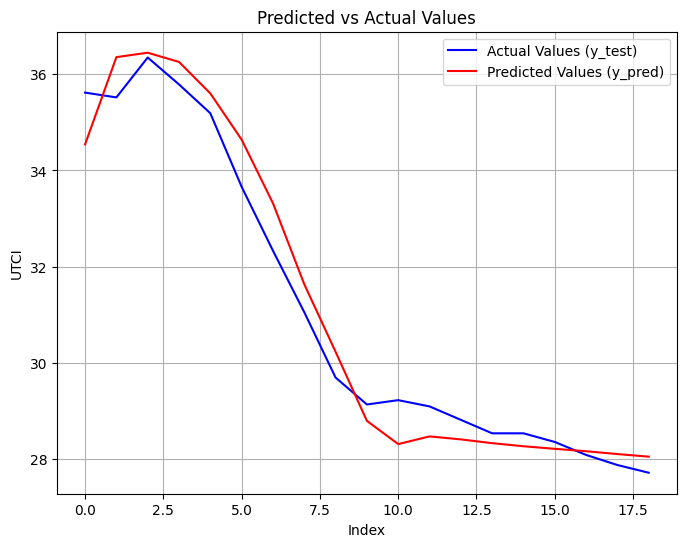

In [43]:
y_pred = df['Predicted']
y_test = df['Actual']
# print(y_pred,y_test)

plt.figure(figsize=(8, 6))

plt.plot(y_test, label='Actual Values (y_test)', color='blue', linestyle='-')
plt.plot(y_pred, label='Predicted Values (y_pred)', color='red', linestyle='-')


plt.title('Predicted vs Actual Values')
plt.xlabel('Index')
plt.ylabel('UTCI')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()